<a href="https://colab.research.google.com/github/DrPaulaEkene/Binary_Classification_Of_Uterine-Myoma_ltrasound_Via_ResNet50_And_MobileNet/blob/main/Final_Project_Uterine_Myoma_(Uterine_fibroids)_Ultrasound_image_classification_with_ResNet50_and_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary Classification of Uterine Fibroid Using ResNet50 and MobileNetv3

**This notebook focuses on the Comparative Analysis of the classification performance of Deep Learning Architectures for Uterine Myoma/fibroids: The models explored by this work are Custom ResNet50 vs. Mobile NetV3**

**Import needed libraries**

In [ ]:
# Import needed libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

Import module and mount the drive

In [ ]:
# Import the drive module
from google.colab import drive

# Mount the Google Drive to the Colab environment.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exploratory data analysis

In [ ]:
# Create the data file paths/directories
# Define the base directory
data_directory = "/content/drive/MyDrive/UF_dataset"

# Define directories for training and testing data
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

In [ ]:
# Print the contents of the base directory

# Function to print contents of a directory
def print_directory_contents(directory, subdirs):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        if os.path.exists(subdir_path):
            print(f"\nContents of {subdir_path}:")
            for item in os.listdir(subdir_path):
                print(item)
        else:
            print(f"\n{subdir_path} does not exist.")

print("Contents of the base directory:")
print(os.listdir(data_directory))

# Print the contents of the training directory
print("\nContents of the training directory:")
print(os.listdir(train_directory))
print_directory_contents(train_directory, ['NUF', 'UF'])

# Print the contents of the testing directory
print("\nContents of the testing directory:")
print(os.listdir(test_directory))
print_directory_contents(test_directory, ['NUF', 'UF'])


Contents of the base directory:
['test', 'train']

Contents of the training directory:
['NUF', 'UF']

Contents of /content/drive/MyDrive/UF_dataset/train/NUF:
1.2.826.0.1.3680043.2.461.11229795.52738502.jpg
1.2.826.0.1.3680043.2.461.11229795.3430648987.jpg
1.2.826.0.1.3680043.2.461.11229795.1772417160.jpg
1.2.826.0.1.3680043.2.461.11229794.633760450.jpg
1.2.826.0.1.3680043.2.461.11229794.860311343.jpg
1.2.826.0.1.3680043.2.461.11229795.1498372195.jpg
1.2.826.0.1.3680043.2.461.11229794.1842316383.jpg
1.2.826.0.1.3680043.2.461.11229794.4012097914.jpg
1.2.826.0.1.3680043.2.461.11229793.3773737040.jpg
1.2.826.0.1.3680043.2.461.11229793.3901290947.jpg
1.2.826.0.1.3680043.2.461.11229793.2481103620.jpg
1.2.826.0.1.3680043.2.461.11229793.2196663137.jpg
1.2.826.0.1.3680043.2.461.11229793.1397720427.jpg
1.2.826.0.1.3680043.2.461.11229792.1906047868.jpg
1.2.826.0.1.3680043.2.461.11229792.1969388712.jpg
1.2.826.0.1.3680043.2.461.11229792.3907803295.jpg
1.2.826.0.1.3680043.2.461.11229791.3847885676

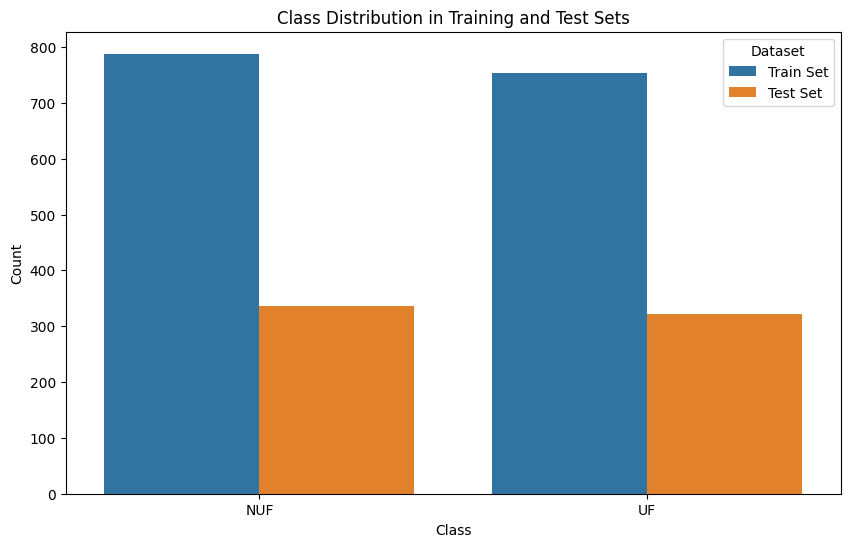

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Get the class names from both the training and test directories
train_classes = os.listdir(train_directory)
test_classes = os.listdir(test_directory)

# Combine and deduplicate the class names
classes = sorted(set(train_classes) | set(test_classes))

# Count the number of samples in each class for both training and test sets
train_class_counts = [len(os.listdir(os.path.join(train_directory, cls))) if cls in train_classes else 0 for cls in classes]
test_class_counts = [len(os.listdir(os.path.join(test_directory, cls))) if cls in test_classes else 0 for cls in classes]

# Combine the data into a DataFrame
df = pd.DataFrame({
    'Class': classes,
    'Train Set': train_class_counts,
    'Test Set': test_class_counts
})

# Melt the DataFrame to have a long format suitable for Seaborn's barplot
df_melted = df.melt(id_vars='Class', var_name='Dataset', value_name='Count')

# Plot the combined class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_melted)
plt.title('Class Distribution in Training and Test Sets')
plt.show()


<ipython-input-13-3245c2951725>:40: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  barplot = sns.barplot(x='Class', y='Count', hue='Dataset', data=df_melted, palette=palette)


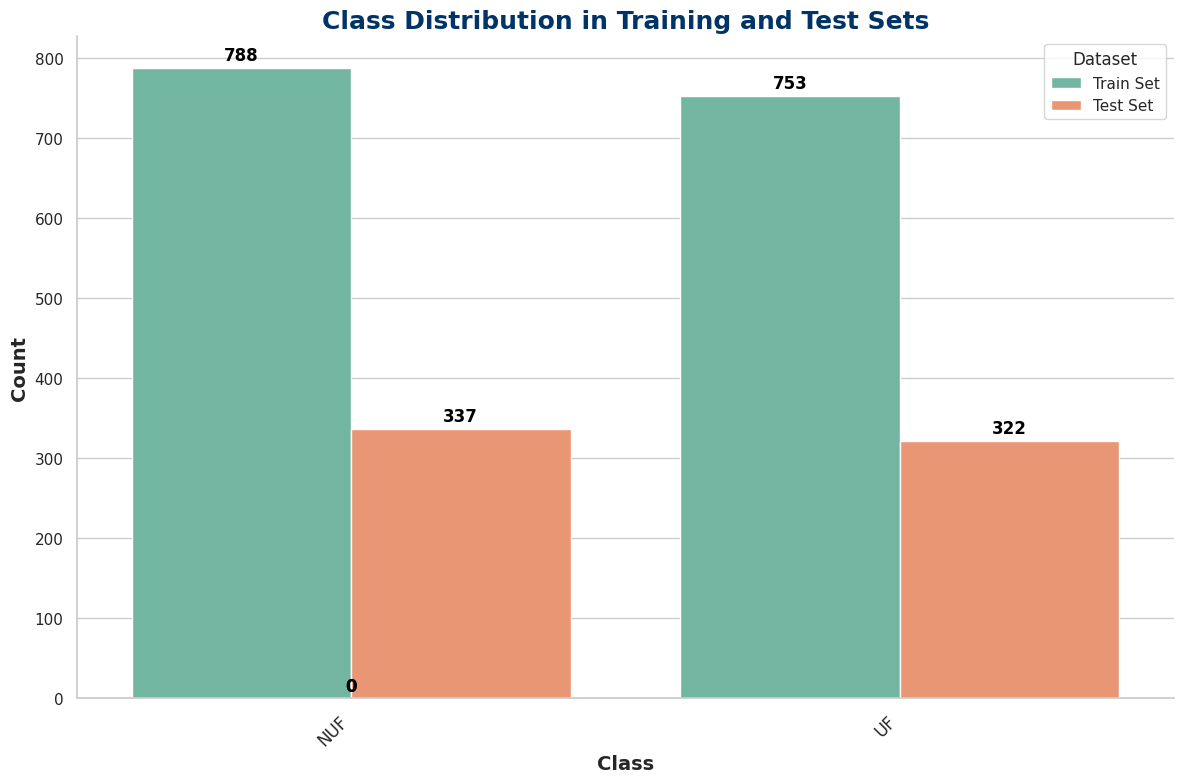

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Get the class names from both the training and test directories
train_classes = os.listdir(train_directory)
test_classes = os.listdir(test_directory)

# Combine the class names
classes = sorted(set(train_classes) | set(test_classes))

# Count the number of samples in each class for both sets
train_class_counts = [len(os.listdir(os.path.join(train_directory, cls))) if cls in train_classes else 0 for cls in classes]
test_class_counts = [len(os.listdir(os.path.join(test_directory, cls))) if cls in test_classes else 0 for cls in classes]

# Combine the data into a DataFrame
df = pd.DataFrame({
    'Class': classes,
    'Train Set': train_class_counts,
    'Test Set': test_class_counts
})

# Melt the DataFrame to have a long format suitable for Seaborn's barplot
df_melted = df.melt(id_vars='Class', var_name='Dataset', value_name='Count')

# Set up the aesthetic bar plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Choose a color palette
palette = sns.color_palette("Set2")

# Create the bar plot
barplot = sns.barplot(x='Class', y='Count', hue='Dataset', data=df_melted, palette=palette)

# Add title and labels with custom fonts
plt.title('Class Distribution in Training and Test Sets', fontsize=18, fontweight='bold', color='#003366')
plt.xlabel('Class', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=12)

# Annotate with count values
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points',
                     fontsize=12, fontweight='bold', color='black')

# despine and show the plot
sns.despine()
plt.tight_layout()
plt.show()

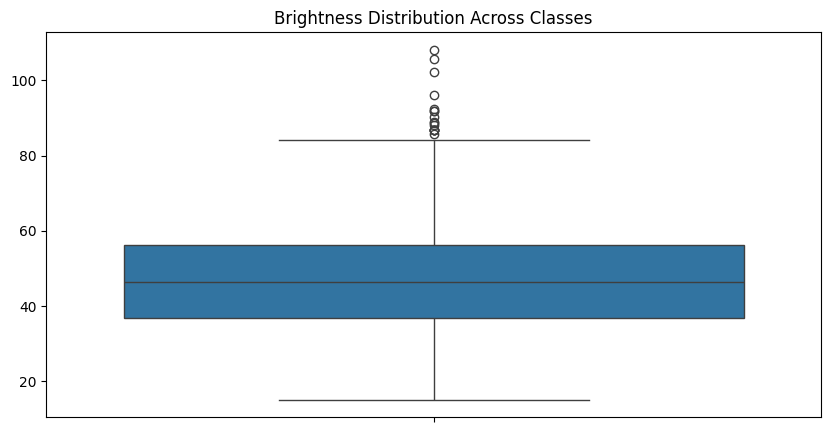

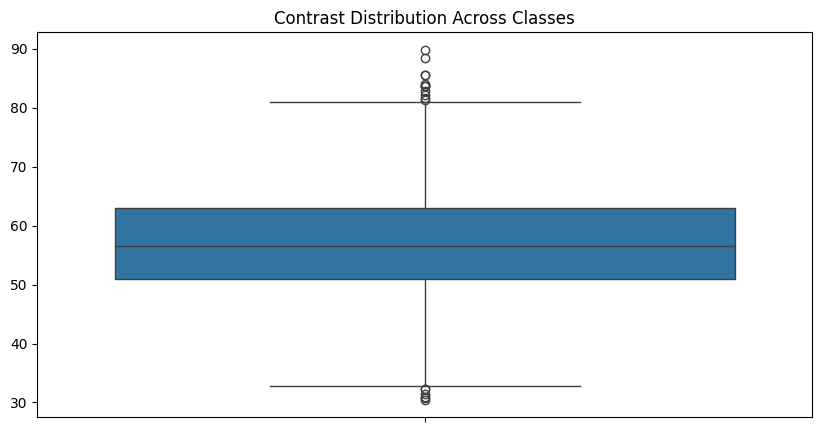

In [ ]:
def calculate_brightness(img):
    return np.mean(img)

def calculate_contrast(img):
    return img.std()

brightness = []
contrast = []
for cls in classes:
    cls_path = os.path.join(train_directory, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        brightness.append(calculate_brightness(img_array))
        contrast.append(calculate_contrast(img_array))

plt.figure(figsize=(10, 5))
sns.boxplot(data=brightness)
plt.title('Brightness Distribution Across Classes')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=contrast)
plt.title('Contrast Distribution Across Classes')
plt.show()


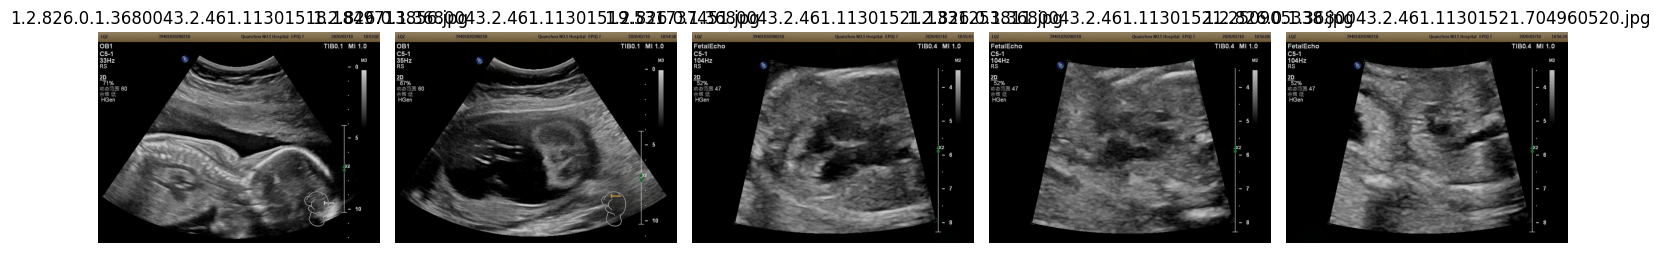

In [ ]:
# Plot 5 images from each directory
import os
import matplotlib.pyplot as plt
from PIL import Image


def plot_images(directory):
    # Get the list of files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))] # Filter out directories

    # Plot up to 5 images from the directory
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.flatten()

    for i, file in enumerate(files[:5]):
        # Load the image
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(file)

    plt.tight_layout()
    plt.show()

# Plot 5 images from the data directory
plot_images(data_directory)

In [ ]:
from collections import defaultdict
import numpy as np

def get_image_shapes(directory):
    shapes = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                with Image.open(img_path) as img:
                    shapes[img.size] += 1
    return shapes

train_shapes = get_image_shapes(train_directory)
test_shapes = get_image_shapes(test_directory)

print("Training set image shapes:", dict(train_shapes))
print("Testing set image shapes:", dict(test_shapes))


Training set image shapes: {(1024, 768): 1364, (1028, 796): 79, (1138, 846): 49, (1026, 766): 2, (1020, 772): 15, (768, 576): 11, (1022, 786): 1, (720, 576): 6, (1920, 1080): 1, (1136, 852): 3, (1160, 844): 1, (1280, 872): 4, (1034, 794): 4, (704, 666): 1}
Testing set image shapes: {(1024, 768): 582, (1028, 796): 32, (1020, 772): 5, (768, 576): 4, (1138, 846): 27, (994, 766): 1, (720, 576): 2, (768, 552): 1, (804, 632): 1, (704, 666): 1, (730, 666): 1, (1034, 794): 1, (1920, 1080): 1}


Preprocessing with imageDataGenerator

Image classification with ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1 = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Train the model
historyRes = model1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


Found 1541 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 750ms/step - accuracy: 0.5192 - loss: 0.6916 - val_accuracy: 0.7709 - val_loss: 0.6452
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 611ms/step - accuracy: 0.6702 - loss: 0.6612 - val_accuracy: 0.7891 - val_loss: 0.6088
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 603ms/step - accuracy: 0.6725 - loss: 0.6382 - val_accuracy: 0.7602 - val_loss: 0.5905
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.7396 - loss: 0.6160 - val_accuracy: 0.7618 - val_loss: 0.5741
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.7215 - loss: 0.6053 - val_accuracy: 0.7845 - val_loss: 0.5561
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.7249 - loss: 0.6076 - val_accuracy: 0.6571 - val_loss: 0.6058
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.7287 - loss: 0.5885 - val_accuracy: 0.7724 - val_loss: 0.5419
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.7413 - loss: 0.5770 - val_accuracy: 0.740

21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 394ms/step
Sensitivity (Recall): 0.54
Specificity: 0.46
Precision: 0.49
F1 Score: 0.52
Harmonic Mean of Precision and Recall: 0.52
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step


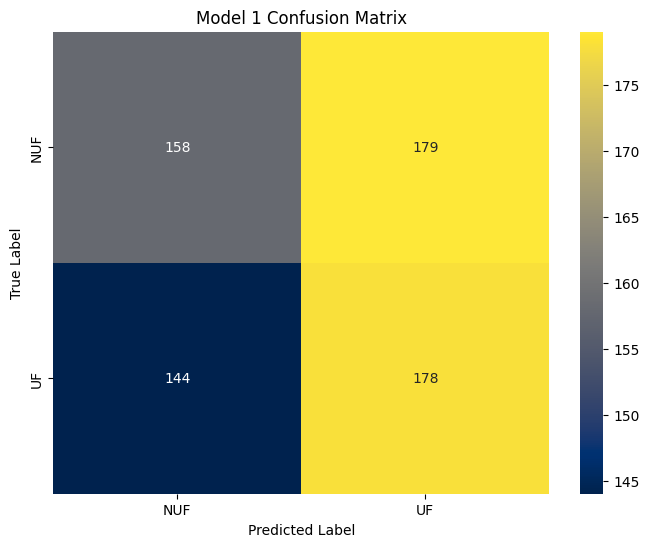

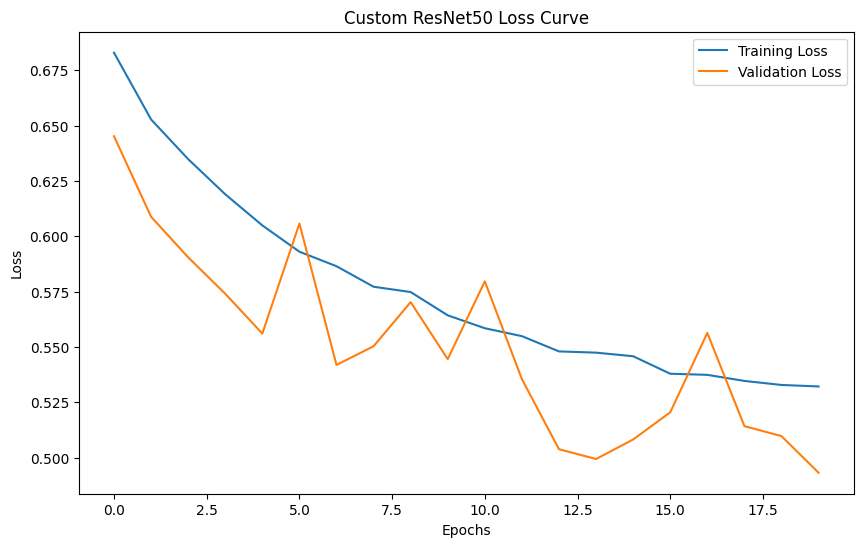

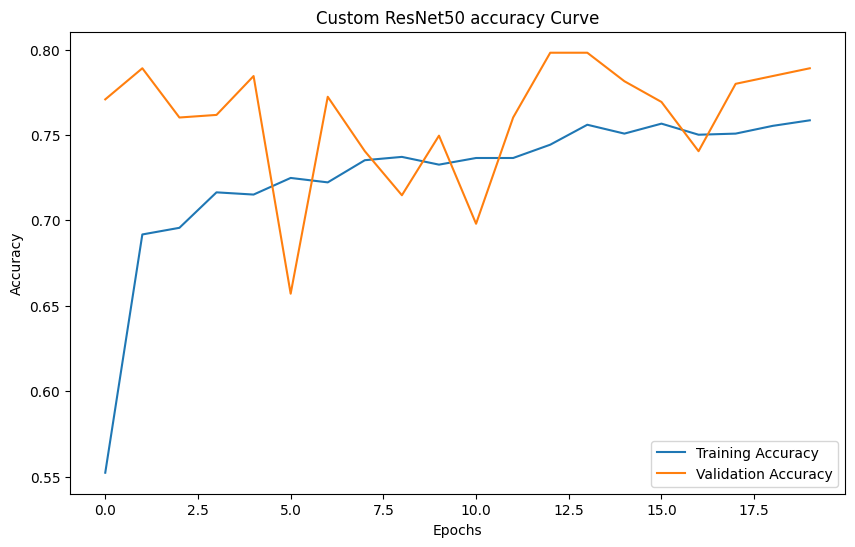

In [ ]:
# Evaluate the Custom ResNet Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import tensorflow as tf

def evaluate_model(model, test_generator, class_labels):
    """
    Evaluate the model on test data and print various metrics.

    Parameters:
    - model: The trained Keras model.
    - test_generator: Keras ImageDataGenerator for test data.
    - class_labels: List of class labels.
    """
    # Get true labels and predictions
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    harmonic_mean = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Print metrics
    print(f'Sensitivity (Recall): {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Harmonic Mean of Precision and Recall: {harmonic_mean:.2f}')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, class_labels, title="Confusion Matrix"):
    """
    Plots the confusion matrix for a given model and test data.

    Parameters:
    - model: Trained model to evaluate.
    - test_generator: The generator for the test data.
    - class_labels: List of class labels for the confusion matrix axes.
    - title: Title of the plot.
    """
    # Predict the classes
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Get the true labels
    y_true = test_generator.classes

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

evaluate_model(model1, test_generator, ['NUF', 'UF'])

plot_confusion_matrix(model1, test_generator, ['NUF', 'UF'],title="Model 1 Confusion Matrix")

# Function to plot loss curve
def plot_loss_curve(history, title='Training and Validation Loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to plot accuracy curve with a customizable title
def plot_accuracy_curve(history, title='Training and Validation Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step


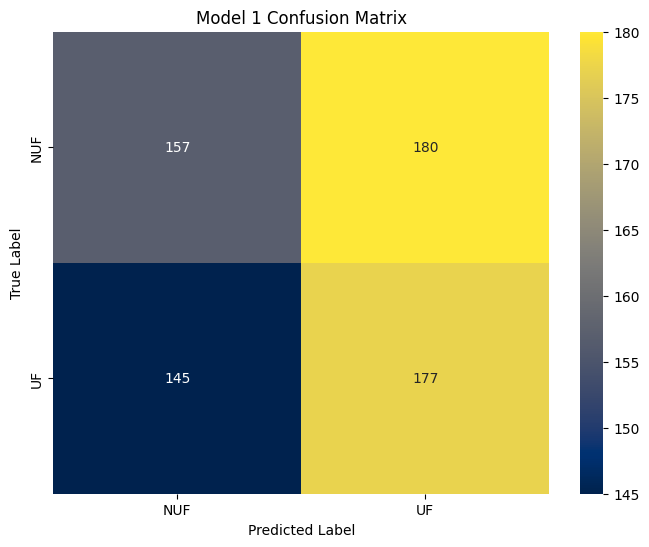

In [ ]:
plot_confusion_matrix(model1, test_generator, ['NUF', 'UF'],title="Model 1 Confusion Matrix")

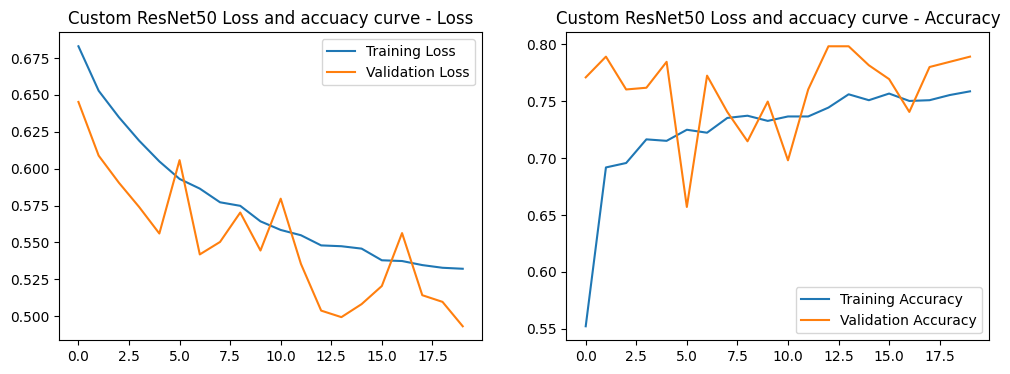

In [ ]:
# Function to plot loss curve
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()

# Plot loss and accuracy curves
plot_history(historyRes, title='Custom ResNet50 Loss and accuacy curve')

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Define a custom callback to monitor accuracy
class BestAccuracyCallback(Callback):
    def __init__(self):
        super(BestAccuracyCallback, self).__init__()
        self.best_accuracy = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("val_accuracy")
        if current_accuracy and current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            print(f"New Best Accuracy: {self.best_accuracy:.4f}")

# Instantiate the custom callback
best_accuracy_callback = BestAccuracyCallback()

# Add 10 more epochs and train the model
historyRes = model1.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[best_accuracy_callback]  # Include the custom callback
)


Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7331 - loss: 0.5500New Best Accuracy: 0.7815
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.7334 - loss: 0.5497 - val_accuracy: 0.7815 - val_loss: 0.4958
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 608ms/step - accuracy: 0.7746 - loss: 0.5119 - val_accuracy: 0.7557 - val_loss: 0.5417
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.7523 - loss: 0.5269 - val_accuracy: 0.7466 - val_loss: 0.5603
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7638 - loss: 0.5140New Best Accuracy: 0.7830
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/step - accuracy: 0.7636 - loss: 0.5142 - val_accuracy: 0.7830 - val_loss: 0.5115
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7533 - loss: 0.5271New Best Accuracy: 0.7936
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.7534 - loss: 0.5270 - val_accuracy: 0.7936 - val_loss: 0.4871
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - a

In [ ]:
# Evaluate the model, model1
metrics = model1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')
print(f'Best Validation Accuracy During Training: {best_accuracy_callback.best_accuracy:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.7551 - loss: 0.5647
ResNet50 Test Accuracy: 0.79
Best Validation Accuracy During Training: 0.8088


In [ ]:
evaluate_model(model1, test_generator, ['NUF', 'UF'])

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step
Sensitivity (Recall): 0.62
Specificity: 0.40
Precision: 0.50
F1 Score: 0.56
Harmonic Mean of Precision and Recall: 0.56


**Modify the model further for better results**

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step


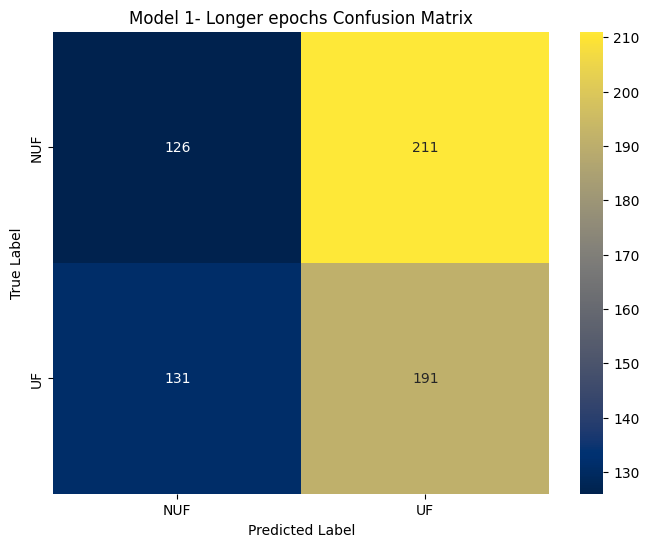

In [ ]:
# Evaluate model1 again
plot_confusion_matrix(model1, test_generator, ['NUF', 'UF'],title="Model 1- Longer epochs Confusion Matrix")

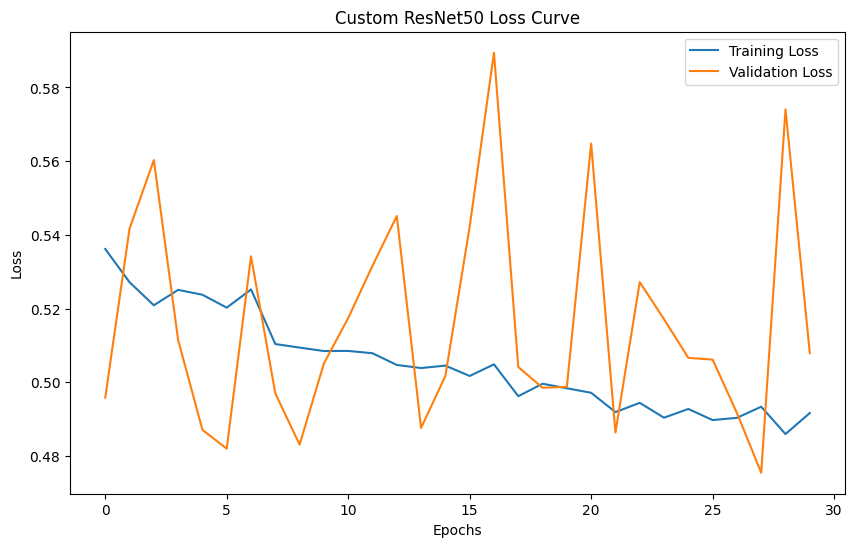

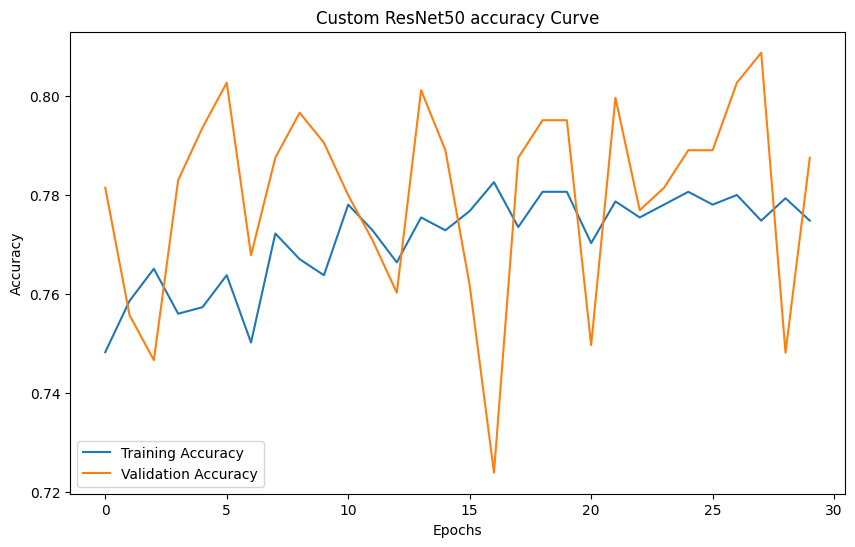

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes, title='Custom ResNet50 Loss Curve')
plot_accuracy_curve(historyRes,title='Custom ResNet50 accuracy Curve' )

In [ ]:
# Unfreeze layers, Model1b

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 without the top (classification) layer
resnet_with_top = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers (last 10) of the model
for layer in resnet_with_top.layers[-10:]:
    layer.trainable = True

# Add a custom head for binary classification - UF and NUF
model1b = Sequential([
    resnet_with_top,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1b.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history_with_top = model1b.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model1b.evaluate(test_generator)
print(f'ResNet50 with Top Layer Test Accuracy: {accuracy:.2f}')

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7603 - loss: 0.4818 - val_accuracy: 0.5114 - val_loss: 0.9270 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 635ms/step - accuracy: 0.9348 - loss: 0.1758 - val_accuracy: 0.5114 - val_loss: 2.3251 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 623ms/step - accuracy: 0.9481 - loss: 0.1189 - val_accuracy: 0.5114 - val_loss: 4.2450 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 636ms/step - accuracy: 0.9725 - loss: 0.0754 - val_accuracy: 0.5114 - val_loss: 0.9665 - learning_rate: 1.0000e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 640ms/step - accuracy: 0.9744 - loss: 0.0837 - val_accuracy: 0.5114 - val_loss: 0.8076 - learning_rate: 1.0000e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 629ms/step - accuracy: 0.9862 - loss: 0.0367 - val_accuracy: 0.5144 - val_loss: 0.6959 - learning_rate: 1.0000e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 632ms/step - accur

In [ ]:
evaluate_model(model1b, test_generator, ['NUF', 'UF'])

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step
Sensitivity (Recall): 0.46
Specificity: 0.47
Precision: 0.45
F1 Score: 0.46
Harmonic Mean of Precision and Recall: 0.46


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step


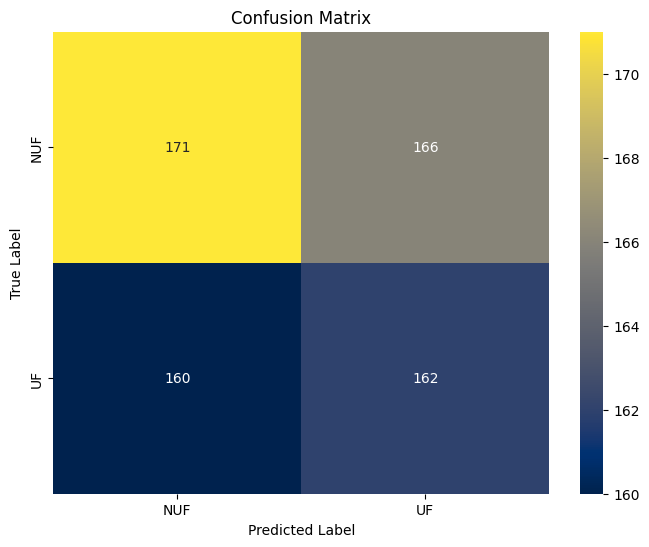

In [ ]:
plot_confusion_matrix(model1b, test_generator, ['NUF', 'UF'])

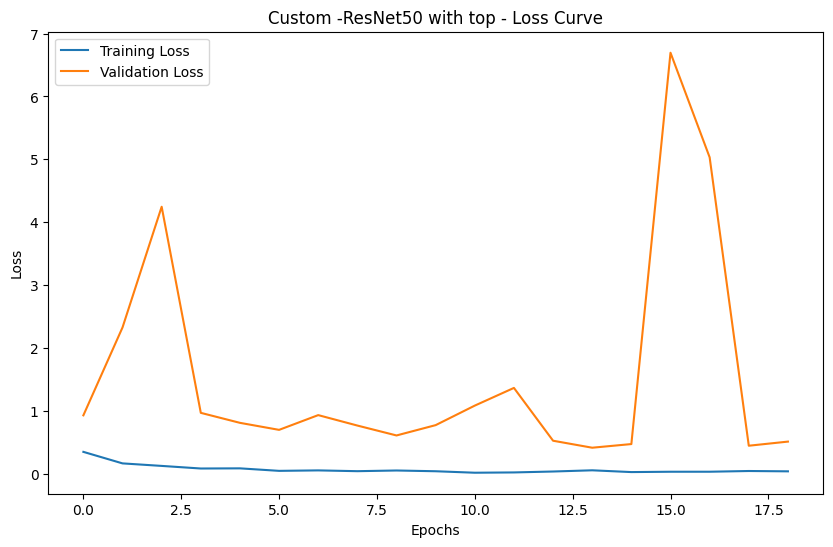

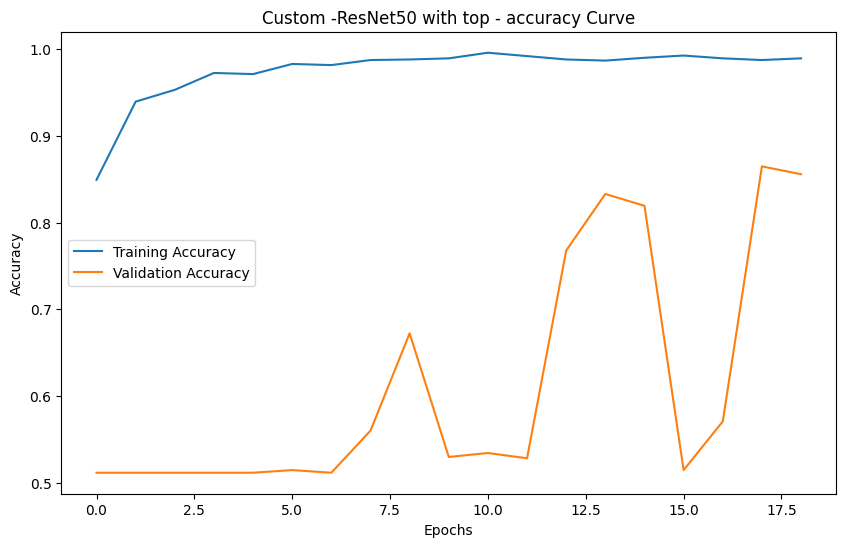

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_with_top, title='Custom -ResNet50 with top - Loss Curve')
plot_accuracy_curve(history_with_top,title='Custom -ResNet50 with top - accuracy Curve' )

Add more layers

In [ ]:
# Increase nodes by 50%
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1c = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1c.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1c.summary()

# Train the model
historyRes_layers = model1c.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model1c.evaluate(test_generator)
print(f'ResNet50layers Test Accuracy: {accuracy:.2f}')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 769ms/step - accuracy: 0.5099 - loss: 0.8660 - val_accuracy: 0.4886 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 619ms/step - accuracy: 0.5008 - loss: 0.7249 - val_accuracy: 0.5129 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 605ms/step - accuracy: 0.4732 - loss: 0.7146 - val_accuracy: 0.5736 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.5172 - loss: 0.6934 - val_accuracy: 0.7527 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 594ms/step - accuracy: 0.5523 - loss: 0.6910 - val_accuracy: 0.7997 - val_loss: 0.6385 - learning_rate: 0.0010
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.4744 - loss: 0.6901
ResNet50layers Test Accuracy: 0.49


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step
Sensitivity (Recall): 1.00
Specificity: 0.00
Precision: 0.49
F1 Score: 0.66
Harmonic Mean of Precision and Recall: 0.66
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step


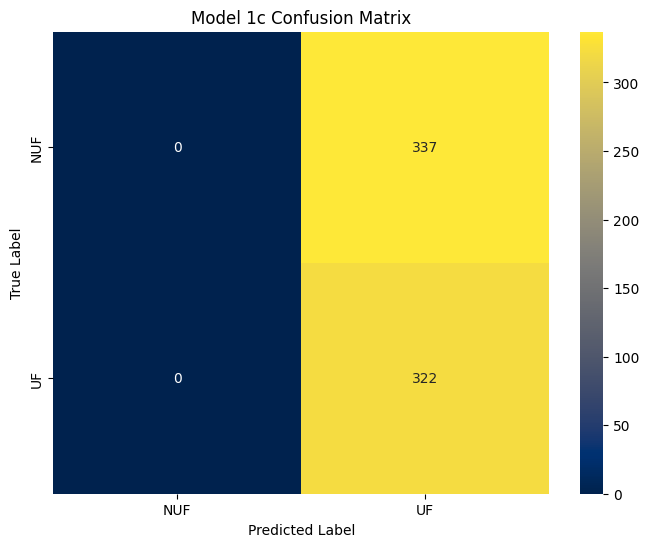

In [ ]:
# Evaluate model1c
evaluate_model(model1c, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1c, test_generator, ['NUF', 'UF'],title="Model 1c Confusion Matrix")

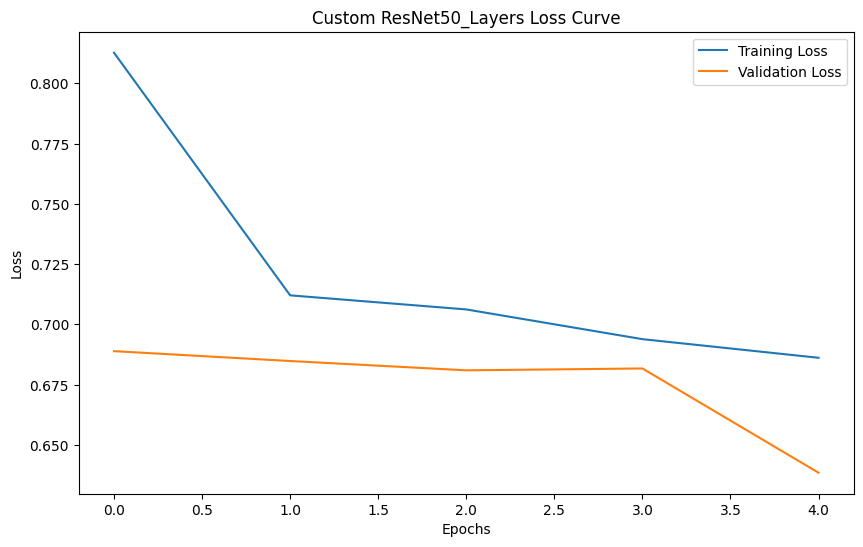

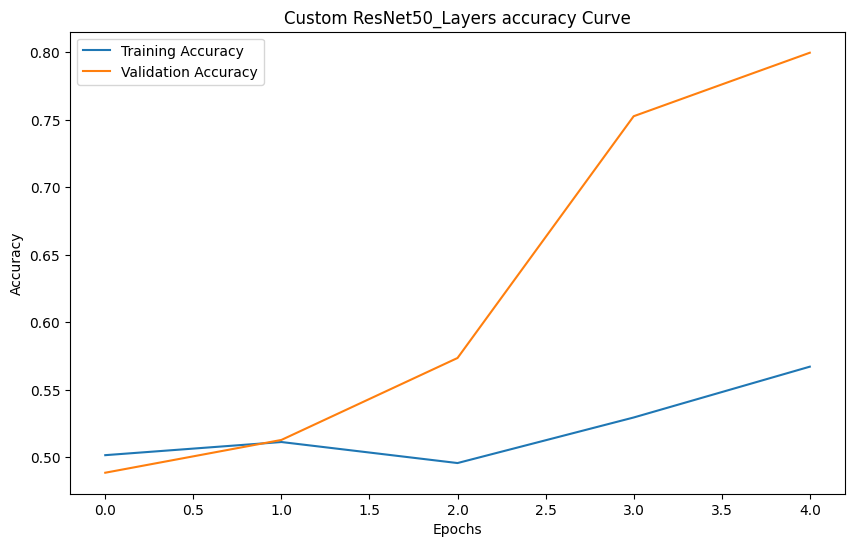

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes_layers, title='Custom ResNet50_Layers Loss Curve')
plot_accuracy_curve(historyRes_layers, title='Custom ResNet50_Layers accuracy Curve')

In [ ]:
# Increase patience levels
#  Adjust the learning rate when the validation loss stops improving


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1d = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1d.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with callback
historyRes_layer_Lr = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Evaluate the model
model1d.load_weights('best_model.keras')
loss, accuracy = model1d.evaluate(test_generator)
print(f'ResNet50_Layer Test Accuracy: {accuracy:.2f}')


NameError: name 'ModelCheckpoint' is not defined

In [ ]:
evaluate_model(model1d, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1d, test_generator, ['NUF', 'UF'])

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyRes_layer_Lr, title='Custom ResNet50_Layers_Lr Loss Curve')
plot_accuracy_curve(historyRes_layer_Lr, title='Custom ResNet50_Layers_Lr accuracy Curve')

In [ ]:
# Balance classes and train with best model so far
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Balance class and train with the model with the highest accuracy so far
class_names = ['NUF', 'UF']
class_indices = train_generator.class_indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=list(class_indices.values()),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model with class weights and callbacks
history_class_bal = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)


In [ ]:
# Evaluate the model using the best saved model
model1d.load_weights('best_model.keras')
loss, accuracy = model1d.evaluate(test_generator)
print(f'ResNet50_Class_Balance Test Accuracy: {accuracy:.2f}')

In [ ]:
evaluate_model(model1, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(model1d, test_generator, ['NUF', 'UF'],title="Model 1e Confusion Matrix")

In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_class_bal, title='Custom ResNet50_class_Balance Loss Curve')
plot_accuracy_curve(history_class_bal,title='Custom ResNet50_Class_Balance accuracy Curve' )


In [ ]:
# Train the model with class weights and callbacks
history_class_bal = model1d.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint]
)


In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(history_class_bal, title='Custom ResNet50_class_Balance Loss Curve')
plot_accuracy_curve(history_class_bal,title='Custom ResNet50_Class_Balance accuracy Curve' )

Initiate MobileNet

In [ ]:
# Make all necessary imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

In [ ]:
# Load MobileNetV3 Large model without the top layer
mobilenet_v3_base = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in mobilenet_v3_base.layers:
    layer.trainable = False

# Add custom layers on top
model_with_top = Sequential([
    mobilenet_v3_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model_with_top.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Train the model
historyMob = model_with_top.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model_with_top.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements Test Accuracy: {accuracy:.2f}')


In [ ]:
evaluate_model(model_with_top, test_generator, ['NUF', 'UF'])

plot_confusion_matrix(model_with_top, test_generator, ['NUF', 'UF'],title="MobileNet 1 Confusion Matrix")


In [ ]:
# Plot loss and accuracy curves
plot_loss_curve(historyMob, title='Mobile Net Loss Curve')
plot_accuracy_curve(historyMob,title='obile Net accuracy Curve' )

In [ ]:
# Increase model complexity gradually
MobileNet2 = Sequential([
    mobilenet_v3_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
MobileNet2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Train the model
historyMob_morcomplex = MobileNet2.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

In [ ]:
# Evaluate the model on the test data
loss, accuracy = MobileNet2.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements Test Accuracy: {accuracy:.2f}')

In [ ]:
evaluate_model(MobileNet2, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(MobileNet2, test_generator, ['NUF', 'UF'],title="MobileNet Complex Confusion Matrix")

In [ ]:
# resplit into 70:30 and try with the best models, while balancing the dataset

import os
import shutil
import random
from math import ceil


In [ ]:
import os
import shutil
import random
from math import ceil

# Define directories
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# List classes
classes = os.listdir(train_directory)

for cls in classes:
    train_class_dir = os.path.join(train_directory, cls)
    test_class_dir = os.path.join(test_directory, cls)

    # List all files
    train_files = os.listdir(train_class_dir)
    test_files = os.listdir(test_class_dir)

    total_files = len(train_files) + len(test_files)
    target_train_count = ceil(total_files * 0.7)
    current_train_count = len(train_files)
    files_to_move = current_train_count - target_train_count

    if files_to_move > 0:
        files_to_move = random.sample(train_files, files_to_move)

        for file_name in files_to_move:
            source = os.path.join(train_class_dir, file_name)
            destination = os.path.join(test_class_dir, file_name)
            shutil.move(source, destination)

    elif files_to_move < 0:
        files_to_move = random.sample(test_files, -files_to_move)

        for file_name in files_to_move:
            source = os.path.join(test_class_dir, file_name)
            destination = os.path.join(train_class_dir, file_name)
            shutil.move(source, destination)

# Verify the new split
for cls in classes:
    train_class_dir = os.path.join(train_directory, cls)
    test_class_dir = os.path.join(test_directory, cls)

    train_count = len(os.listdir(train_class_dir))
    test_count = len(os.listdir(test_class_dir))

    print(f"Class: {cls}, Train: {train_count}, Test: {test_count}, Ratio: {train_count / (train_count + test_count):.2f}")


In [ ]:
# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

# Create model
model1 = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Train the model
historyRes = model1.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')

# increase epochs and introduce dropout

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()

# Set up EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with callback
historyRes_layer_Lr = model1.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model1.evaluate(test_generator)
print(f'ResNet50 Test Accuracy: {accuracy:.2f}')


In [ ]:
# Train again with the MobileNet
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
data_directory = "/content/drive/MyDrive/UF_dataset"
train_directory = "/content/drive/MyDrive/UF_dataset/train"
test_directory = "/content/drive/MyDrive/UF_dataset/test"

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


# Train the model
historyMob_Class_Bal = MobileNet2.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


In [ ]:
# Evaluate the model on the test data
loss, accuracy = MobileNet2.evaluate(test_generator)
print(f'MobileNetV3 Large with Custom Enhancements_resplit Test Accuracy: {accuracy:.2f}')

In [ ]:
evaluate_model(MobileNet2, test_generator, ['NUF', 'UF'])
plot_confusion_matrix(MobileNet2, test_generator, ['NUF', 'UF'],title="MobileNet Complex Confusion Matrix")